In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [2]:
original_data_df = pd.read_csv("E:/Carrier/zeta-disease.csv")

In [3]:
original_data_df.head()

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
0,54,189,27.1,80,0,1.5038,0,10,0
1,23,150,38.5,68,71,0.3868,55,2,0
2,47,186,29.9,90,0,0.2728,0,7,0
3,18,150,30.8,70,1033,0.6598,56,0,0
4,24,160,32.4,74,125,0.7608,59,2,0


In [4]:
original_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 800 non-null    int64  
 1   weight              800 non-null    int64  
 2   bmi                 800 non-null    float64
 3   blood_pressure      800 non-null    int64  
 4   insulin_test        800 non-null    int64  
 5   liver_stress_test   800 non-null    float64
 6   cardio_stress_test  800 non-null    int64  
 7   years_smoking       800 non-null    int64  
 8   zeta_disease        800 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 56.4 KB


In [5]:
X = original_data_df.drop(['zeta_disease'], axis = 1)
y = original_data_df.drop(['age', 'weight', 'bmi', 'blood_pressure', 'insulin_test', 'liver_stress_test', 'cardio_stress_test', 'years_smoking'], axis = 1)

In [6]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
age,800.0,30.985000,13.824025,18.0000,21.0000,26.0000,38.0000,109.0000
weight,800.0,172.407500,31.942438,94.0000,149.0000,167.0000,192.0000,308.0000
bmi,800.0,32.201625,8.549155,0.0000,27.3000,32.0500,36.5250,86.1000
blood_pressure,800.0,69.565000,19.874784,0.0000,62.0000,72.0000,80.0000,157.0000
insulin_test,800.0,85.887500,126.333656,0.0000,0.0000,45.0000,130.0000,1077.0000
liver_stress_test,800.0,0.544496,0.348711,0.1408,0.3078,0.4453,0.6998,3.4813
cardio_stress_test,800.0,43.121250,30.409949,0.0000,0.0000,53.0000,62.0000,214.0000
years_smoking,800.0,4.051250,4.176173,0.0000,1.0000,3.0000,6.0000,40.0000


In [7]:
# Lets check the correlation between X variables. There is not much of a correlation here.
# In the subsequent steps we will use VIF score to check the presence of multicollinearity.
# The only thing we can observe is between cardiac_stress_test and insulin_test.
# Other one is between age and years_smoking which is obvious.
X.corr()

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking
age,1.000000,0.157705,0.035347,0.193066,-0.034294,0.042416,-0.106039,0.372373
weight,0.157705,1.000000,0.214262,0.122349,0.304295,0.146779,0.053629,0.100834
bmi,0.035347,0.214262,1.000000,0.240513,0.217265,0.116649,0.264861,0.028683
blood_pressure,0.193066,0.122349,0.240513,1.000000,0.079425,0.045764,0.193221,0.095613
insulin_test,-0.034294,0.304295,0.217265,0.079425,1.000000,0.175230,0.417894,-0.006292
liver_stress_test,0.042416,0.146779,0.116649,0.045764,0.175230,1.000000,0.172048,0.021817
cardio_stress_test,-0.106039,0.053629,0.264861,0.193221,0.417894,0.172048,1.000000,-0.080358
years_smoking,0.372373,0.100834,0.028683,0.095613,-0.006292,0.021817,-0.080358,1.000000


In [8]:
#This block is the check if there are null values. But as we see below, there are no null values in this data set.
#So, no need to impute any values.
X.isnull().sum()

age                   0
weight                0
bmi                   0
blood_pressure        0
insulin_test          0
liver_stress_test     0
cardio_stress_test    0
years_smoking         0
dtype: int64

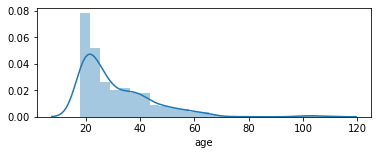

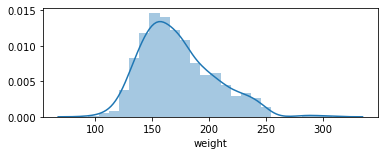

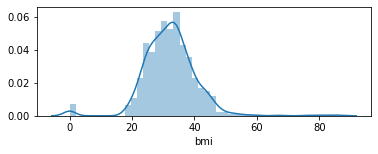

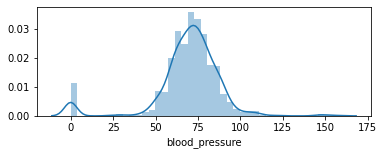

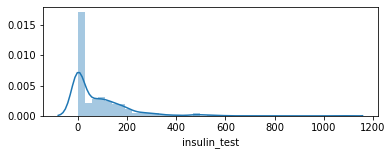

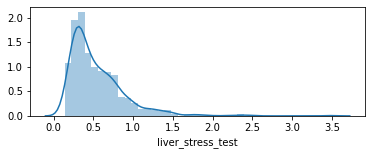

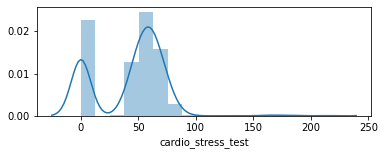

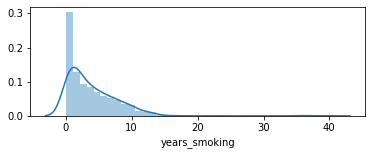

In [9]:
plt.rcParams['figure.figsize'] = [6, 2]
for column in X.columns:
    plt.figure()
    sns.distplot(X[column])

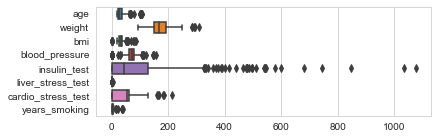

In [10]:
sns.set_style("whitegrid") 
ax = sns.boxplot(data=X, orient="h") 

# A zero bmi and blood pressure is wrong data. We need to impute here.

# Zero insulin level is like zero blood sugar and it's not possible. So, there is something wrong with the data. We have almost 50% data with zero insulin level. Even if we want, we can't impute as it's not advisable.

# A cardiac stress score of zero is the best. Scores between 1 and 100 indicate a low level of risk, scores from 100 to 400 indicate an increased risk with treatment recommended, and a score over 400 identifies patients at highest risk for heart attack.

In [11]:
X.isnull().sum()

age                   0
weight                0
bmi                   0
blood_pressure        0
insulin_test          0
liver_stress_test     0
cardio_stress_test    0
years_smoking         0
dtype: int64

In [12]:
X

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking
0,54,189,27.1,80,0,1.5038,0,10
1,23,150,38.5,68,71,0.3868,55,2
2,47,186,29.9,90,0,0.2728,0,7
3,18,150,30.8,70,1033,0.6598,56,0
4,24,160,32.4,74,125,0.7608,59,2
...,...,...,...,...,...,...,...,...
795,26,161,28.4,90,78,0.5578,42,3
796,37,165,33.7,60,0,0.3078,69,6
797,27,166,25.6,74,0,0.2638,0,5
798,109,139,28.1,66,94,0.2298,53,1


In [13]:
X.isnull().sum()

age                   0
weight                0
bmi                   0
blood_pressure        0
insulin_test          0
liver_stress_test     0
cardio_stress_test    0
years_smoking         0
dtype: int64

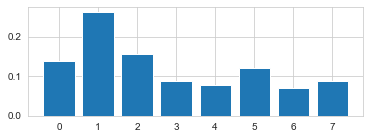

In [14]:
model = RandomForestClassifier()
model.fit(X, y)
importance = model.feature_importances_
importanceList = []
for i,v in enumerate(importance):
    importanceList.append(v)
    #print('Feature: %0d, Score: %.5f' % (i,v))
imp_df = pd.DataFrame()
imp_df['Feature'] = X.columns
imp_df['Importance'] = importanceList

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [15]:
imp_df_sorted = imp_df.sort_values(by = 'Importance', ascending = False)
pd.options.display.float_format = '{:,.3f}'.format
imp_df_sorted

,Feature,Importance
1,weight,0.262
2,bmi,0.157
0,age,0.138
5,liver_stress_test,0.121
7,years_smoking,0.087
3,blood_pressure,0.087
4,insulin_test,0.078
6,cardio_stress_test,0.070


# According to the above value of of variable importance, weight is the most important and cardiac stress test is the least important

# Lets check the Variance Inflation Factor for all the X variable. As a rule of thumb, VIF > 10 is NOT indicates high correlation and is a cause for concern.

In [16]:
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

# As you see below, BP, BMI and Weight have VFI score of more than 10. Now, lets drop bmi as it's calcualted by the formula BMI = Weight in kg/Height.

In [17]:
vif.sort_values(by = 'VIF')

,VIF,features
4,1.868,insulin_test
7,2.268,years_smoking
5,3.625,liver_stress_test
6,4.006,cardio_stress_test
0,7.309,age
3,13.843,blood_pressure
2,16.129,bmi
1,20.150,weight


In [18]:
X.drop(['insulin_test'], axis = 1, inplace = True)

In [19]:
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [20]:
vif.sort_values(by = 'VIF')

,VIF,features
6,2.267,years_smoking
5,3.470,cardio_stress_test
4,3.614,liver_stress_test
0,7.266,age
3,13.638,blood_pressure
2,16.127,bmi
1,19.545,weight


In [21]:
#Lets standardise the data using scikit StandardScaler()

In [22]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X

array([[ 1.66589677,  0.51977498, -0.5971136 , ...,  2.75272183,
        -1.41888518,  1.42534108],
       [-0.57797896, -0.70193508,  0.73718577, ..., -0.45250726,
         0.39086488, -0.4914866 ],
       [ 1.15921516,  0.42579728, -0.26939095, ..., -0.77963001,
        -1.41888518,  0.7065307 ],
       ...,
       [-0.28844661, -0.2007207 , -0.77267931, ..., -0.80545549,
        -1.41888518,  0.22732378],
       [ 5.64696662, -1.04651997, -0.4800698 , ..., -0.90301842,
         0.32505579, -0.73109006],
       [-0.36082969,  0.73905627, -0.29279971, ...,  0.23617223,
        -1.41888518, -0.73109006]])

# As we see now, the above X variables have VIF < 10. So, we are good.

In [23]:
#Lets split the data into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=0)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.81


In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.92      0.86       104
           1       0.80      0.59      0.68        56

    accuracy                           0.81       160
   macro avg       0.81      0.76      0.77       160
weighted avg       0.81      0.81      0.80       160



In [25]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[96  8]
 [23 33]]


In [26]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

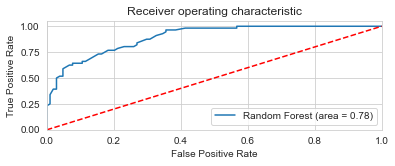

In [27]:
logit_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [28]:
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.825


In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87       104
           1       0.83      0.62      0.71        56

    accuracy                           0.82       160
   macro avg       0.83      0.78      0.79       160
weighted avg       0.83      0.82      0.82       160



# So, the accuracy is better in randomforest i.e. 82.5% and the recall is also better i.e. 62% when compared to LR which is 59%. The f1 score of randomforest is also better i.e. 71% when compared to Logistic Regression which is 68%. So, I would go with RandomForest.